In [1]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt

from Backtest.backtest import Backtest
from Backtest.data import OHLCDataHandler
from KDJStrategy import KDJStrategy
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

In [16]:
def run_backtest(config, trading_data, ohlc_data,
                 window = 10, sK=20, bK=80, delta = 10):
    window = int(window)
    sK = int(sK)
    sD = sK
    sJ = sK - delta
    bK = int(bK)
    bD = bK
    bJ = bK + delta
    config['title'] = "EMVStrategy" + "_" + str(window) + "_" + str(sK) + "_" + str(bK) + "_" + str(delta)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")
    
    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = KDJStrategy(config, events_queue, data_handler,
                         window = window, sK=sK, sD=sD, sJ=sJ, bK=bK, bD=bD, bJ=bJ)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    
    # dict_ans = {
    #     "window": [window],
    #     "sK/sD/sJ": [(sK, sD, sJ)],
    #     "bK/bD/bJ": [(bK, bD, bJ)],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)
    return -1 * (results['cum_returns'][-1] - 1)

In [17]:
def f(params):
    config = {
        "csv_dir": "C:/backtest/Binance",
        "out_dir": "C:/backtest/results/KDJStrategy",
        "title": "KDJStrategy",
        "is_plot": False,
        "save_plot": False,
        "save_tradelog": False,
        "start_date": pd.Timestamp("2017-07-01T00:0:00", freq = "60" + "T"),    # str(freq) + "T"
        "end_date": pd.Timestamp("2018-04-01T00:00:00", freq = "60" + "T"),
        "equity": 1.0,
        "freq": 60,      # min
        "commission_ratio": 0.001,
        "suggested_quantity": None,     # None or a value
        "max_quantity": None,           # None or a value, Maximum purchase quantity
        "min_quantity": None,           # None or a value, Minimum purchase quantity
        "min_handheld_cash": None,      # None or a value, Minimum handheld funds
        "exchange": "Binance",
        "tickers": ['BTCUSDT']
    }
    # trading_data = {}
    # for ticker in config['tickers']:
    #     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
    #     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

    ohlc_data = {}
    for ticker in config['tickers']:
        # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
        ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '_OHLC_60min.h5', key=ticker)

    trading_data = None
    
    window = params['window']
    sK = params['sK']
    bK = params['bK']
    delta = params['delta']
    val = run_backtest(config, trading_data, ohlc_data, window, sK, bK, delta)
    return {'loss': val, 'status': STATUS_OK}

In [43]:
space['window']

In [22]:
space = {
#     'config': hp.choice('config', [config]),
#     'ohlc_data': hp.choice('ohlc_data', [ohlc_data]),
#     'trading_data': hp.choice('trading_data', [trading_data]),
    'window': hp.choice('window', tuple(np.arange(1, 240, 1))),
    'sK': hp.choice('sK', tuple(np.arange(10, 30, 1))),
    'bK': hp.choice('bK', tuple(np.arange(70, 90, 1))),
    'delta': hp.choice('delta', tuple(np.arange(-20, 20, 1)))
}

In [24]:
trials = Trials()

In [25]:
best = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=250, trials=trials)

---------------------------------
EMVStrategy_152_18_80_18
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.6089177230
Max Drawdown: 62.1672933886
Max Drawdown Duration: 2510
Total Returns: 0.1494889382
---------------------------------
Trades: 7
Trade Winning: 43%
Average Trade: 8.27%
Average Win: 39.66%
Average Loss: -15.27%
Best Trade: 104.51%
Worst Trade: -33.66%
Worst Trade Date: 20 days 13:00:00
Avg Days in Trade: 13 days 20:42:51
---------------------------------
---------------------------------
EMVStrategy_234_14_86_-18
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
-----

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.6808567216
Max Drawdown: 63.5317983716
Max Drawdown Duration: 2510
Total Returns: 0.1884917739
---------------------------------
Trades: 16
Trade Winning: 50%
Average Trade: 3.39%
Average Win: 16.31%
Average Loss: -9.52%
Best Trade: 85.60%
Worst Trade: -28.56%
Worst Trade Date: 5 days 21:00:00
Avg Days in Trade: 7 days 07:30:00
---------------------------------
---------------------------------
EMVStrategy_25_17_74_-11
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.5432255929
Max Drawdown: 67.2684921275
Max Drawdown Duration: 2510
Total Returns: 0.0874594105
---------------------------------
Trades: 22
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6151211090
Max Drawdown: 45.2249654443
Max Drawdown Duration: 2510
Total Returns: 0.8624703344
---------------------------------
Trades: 7
Trade Winning: 43%
Average Trade: 15.06%
Average Win: 47.31%
Average Loss: -9.13%
Best Trade: 113.60%
Worst Trade: -13.54%
Worst Trade Date: 2 days 00:00:00
Avg Days in Trade: 11 days 11:34:17
---------------------------------
---------------------------------
EMVStrategy_189_28_72_-17
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5137386017
Max Drawdown: 45.1153776212
Max Drawdown Duration: 2510
Total Returns: 0.7815433781
---------------------------------
Trades: 7
Trade Win

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4308436055
Max Drawdown: 48.0256734791
Max Drawdown Duration: 2736
Total Returns: 0.7819248462
---------------------------------
Trades: 13
Trade Winning: 46%
Average Trade: 7.25%
Average Win: 24.62%
Average Loss: -7.64%
Best Trade: 91.98%
Worst Trade: -13.38%
Worst Trade Date: 3 days 00:00:00
Avg Days in Trade: 7 days 00:46:09
---------------------------------
---------------------------------
EMVStrategy_107_27_84_1
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5313220707
Max Drawdown: 50.2857094582
Max Drawdown Duration: 2510
Total Returns: 0.8294961777
---------------------------------
Trades: 10
Trade Winnin

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5195841875
Max Drawdown: 43.6131521261
Max Drawdown Duration: 2510
Total Returns: 0.7317950216
---------------------------------
Trades: 6
Trade Winning: 50%
Average Trade: 15.86%
Average Win: 44.15%
Average Loss: -12.43%
Best Trade: 108.62%
Worst Trade: -15.66%
Worst Trade Date: 4 days 23:00:00
Avg Days in Trade: 12 days 03:50:00
---------------------------------
---------------------------------
EMVStrategy_188_29_81_-16
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6894005794
Max Drawdown: 38.1943481468
Max Drawdown Duration: 2510
Total Returns: 0.9111428133
---------------------------------
Trades: 6
Trade Wi

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0458660808
Max Drawdown: 53.5248484233
Max Drawdown Duration: 2510
Total Returns: 0.5004087370
---------------------------------
Trades: 6
Trade Winning: 50%
Average Trade: 9.38%
Average Win: 25.70%
Average Loss: -6.95%
Best Trade: 56.16%
Worst Trade: -14.41%
Worst Trade Date: 2 days 23:00:00
Avg Days in Trade: 20 days 17:50:00
---------------------------------
---------------------------------
EMVStrategy_195_11_81_-12
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.4558894023
Max Drawdown: 61.9693294766
Max Drawdown Duration: 2510
Total Returns: 0.0615307766
---------------------------------
Trades: 6
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7604248440
Max Drawdown: 54.5639537291
Max Drawdown Duration: 2510
Total Returns: 1.0314074559
---------------------------------
Trades: 9
Trade Winning: 44%
Average Trade: 14.90%
Average Win: 46.21%
Average Loss: -10.14%
Best Trade: 142.82%
Worst Trade: -17.66%
Worst Trade Date: 1 days 18:00:00
Avg Days in Trade: 9 days 07:06:40
---------------------------------
---------------------------------
EMVStrategy_66_25_83_13
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8518368668
Max Drawdown: 54.0511047198
Max Drawdown Duration: 2736
Total Returns: 0.3120695718
---------------------------------
Trades: 16
Trade Winn

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9333033151
Max Drawdown: 63.7469340175
Max Drawdown Duration: 2510
Total Returns: 0.3859949082
---------------------------------
Trades: 13
Trade Winning: 46%
Average Trade: 5.65%
Average Win: 24.21%
Average Loss: -10.26%
Best Trade: 93.12%
Worst Trade: -24.88%
Worst Trade Date: 3 days 09:00:00
Avg Days in Trade: 7 days 17:04:37
---------------------------------
---------------------------------
EMVStrategy_175_12_71_3
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.3051367750
Max Drawdown: 66.2805235673
Max Drawdown Duration: 2510
Total Returns: -0.0345553624
---------------------------------
Trades: 7
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7930346518
Max Drawdown: 50.6370303344
Max Drawdown Duration: 2510
Total Returns: 1.0559900416
---------------------------------
Trades: 8
Trade Winning: 50%
Average Trade: 15.32%
Average Win: 39.28%
Average Loss: -8.64%
Best Trade: 125.90%
Worst Trade: -16.24%
Worst Trade Date: 3 days 15:00:00
Avg Days in Trade: 10 days 22:22:30
---------------------------------
---------------------------------
EMVStrategy_103_28_70_1
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0266514773
Max Drawdown: 54.8325676958
Max Drawdown Duration: 2510
Total Returns: 0.4419712746
---------------------------------
Trades: 14
Trade Winn

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8439241563
Max Drawdown: 55.8980131357
Max Drawdown Duration: 2510
Total Returns: 0.3072077415
---------------------------------
Trades: 6
Trade Winning: 50%
Average Trade: 11.17%
Average Win: 39.93%
Average Loss: -17.58%
Best Trade: 102.36%
Worst Trade: -27.73%
Worst Trade Date: 11 days 15:00:00
Avg Days in Trade: 14 days 12:20:00
---------------------------------
---------------------------------
EMVStrategy_209_28_78_10
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.8379152595
Max Drawdown: 36.9854540180
Max Drawdown Duration: 2510
Total Returns: 0.9891346709
---------------------------------
Trades: 6
Trade Wi

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8574035538
Max Drawdown: 52.4116451415
Max Drawdown Duration: 2510
Total Returns: 0.3082020001
---------------------------------
Trades: 5
Trade Winning: 60%
Average Trade: 11.51%
Average Win: 33.23%
Average Loss: -21.07%
Best Trade: 83.90%
Worst Trade: -28.73%
Worst Trade Date: 11 days 10:00:00
Avg Days in Trade: 15 days 08:12:00
---------------------------------
---------------------------------
EMVStrategy_177_28_73_5
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9896587093
Max Drawdown: 58.6759104905
Max Drawdown Duration: 2510
Total Returns: 0.4002465369
---------------------------------
Trades: 8
Trade Winn

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0095152403
Max Drawdown: 43.8270691694
Max Drawdown Duration: 2736
Total Returns: 0.4275828739
---------------------------------
Trades: 17
Trade Winning: 41%
Average Trade: 3.19%
Average Win: 17.24%
Average Loss: -6.65%
Best Trade: 38.38%
Worst Trade: -11.13%
Worst Trade Date: 1 days 22:00:00
Avg Days in Trade: 5 days 05:49:25
---------------------------------
---------------------------------
EMVStrategy_157_26_88_-20
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4045976588
Max Drawdown: 46.4473766200
Max Drawdown Duration: 2510
Total Returns: 0.6853217819
---------------------------------
Trades: 7
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9244608851
Max Drawdown: 55.6507856544
Max Drawdown Duration: 2736
Total Returns: 0.3595702292
---------------------------------
Trades: 12
Trade Winning: 50%
Average Trade: 4.13%
Average Win: 18.14%
Average Loss: -9.88%
Best Trade: 39.17%
Worst Trade: -17.21%
Worst Trade Date: 2 days 06:00:00
Avg Days in Trade: 6 days 22:50:00
---------------------------------
---------------------------------
EMVStrategy_118_10_89_11
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.0513104696
Max Drawdown: 72.2420440662
Max Drawdown Duration: 2510
Total Returns: -0.1835637680
---------------------------------
Trades: 7
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8471444719
Max Drawdown: 61.2543020073
Max Drawdown Duration: 2510
Total Returns: 0.3211855112
---------------------------------
Trades: 18
Trade Winning: 50%
Average Trade: 4.54%
Average Win: 19.46%
Average Loss: -10.38%
Best Trade: 106.94%
Worst Trade: -28.56%
Worst Trade Date: 5 days 21:00:00
Avg Days in Trade: 6 days 07:53:20
---------------------------------
---------------------------------
EMVStrategy_33_24_75_7
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0214715417
Max Drawdown: 57.5674306467
Max Drawdown Duration: 2510
Total Returns: 0.4644858164
---------------------------------
Trades: 25
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8667538614
Max Drawdown: 53.8440653753
Max Drawdown Duration: 2510
Total Returns: 0.3236372171
---------------------------------
Trades: 6
Trade Winning: 50%
Average Trade: 10.53%
Average Win: 37.22%
Average Loss: -16.16%
Best Trade: 94.60%
Worst Trade: -24.47%
Worst Trade Date: 12 days 02:00:00
Avg Days in Trade: 14 days 17:50:00
---------------------------------
---------------------------------
EMVStrategy_186_19_82_-18
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7916101869
Max Drawdown: 54.8789478861
Max Drawdown Duration: 2510
Total Returns: 0.2714530015
---------------------------------
Trades: 6
Trade Wi

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.3428825697
Max Drawdown: 62.3537040044
Max Drawdown Duration: 2510
Total Returns: -0.0145087442
---------------------------------
Trades: 52
Trade Winning: 48%
Average Trade: 0.62%
Average Win: 7.87%
Average Loss: -6.09%
Best Trade: 41.17%
Worst Trade: -19.09%
Worst Trade Date: 3 days 03:00:00
Avg Days in Trade: 1 days 22:30:00
---------------------------------
---------------------------------
EMVStrategy_40_23_74_-20
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9583148006
Max Drawdown: 52.3685700549
Max Drawdown Duration: 2510
Total Returns: 0.4097372333
---------------------------------
Trades: 23
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7877523831
Max Drawdown: 53.5637714704
Max Drawdown Duration: 2510
Total Returns: 0.2654111703
---------------------------------
Trades: 5
Trade Winning: 60%
Average Trade: 11.38%
Average Win: 33.66%
Average Loss: -22.03%
Best Trade: 89.45%
Worst Trade: -28.73%
Worst Trade Date: 11 days 10:00:00
Avg Days in Trade: 15 days 11:12:00
---------------------------------
---------------------------------
EMVStrategy_164_19_71_14
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.1676032275
Max Drawdown: 71.1618108003
Max Drawdown Duration: 2510
Total Returns: -0.1067007661
---------------------------------
Trades: 8
Trade Wi

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.3974228667
Max Drawdown: 58.0387897061
Max Drawdown Duration: 2510
Total Returns: 0.7376791550
---------------------------------
Trades: 11
Trade Winning: 36%
Average Trade: 11.31%
Average Win: 49.27%
Average Loss: -10.38%
Best Trade: 148.58%
Worst Trade: -17.92%
Worst Trade Date: 2 days 05:00:00
Avg Days in Trade: 8 days 06:54:33
---------------------------------
---------------------------------
EMVStrategy_148_28_71_-9
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.6249219692
Max Drawdown: 69.8003285168
Max Drawdown Duration: 2510
Total Returns: 0.1650709935
---------------------------------
Trades: 10
Trade Wi

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.4130849920
Max Drawdown: 82.4801360569
Max Drawdown Duration: 2510
Total Returns: -0.4393634854
---------------------------------
Trades: 9
Trade Winning: 22%
Average Trade: -3.37%
Average Win: 34.85%
Average Loss: -14.30%
Best Trade: 63.32%
Worst Trade: -28.40%
Worst Trade Date: 12 days 13:00:00
Avg Days in Trade: 14 days 02:46:40
---------------------------------
---------------------------------
EMVStrategy_171_15_77_17
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.3335692442
Max Drawdown: 66.4585056368
Max Drawdown Duration: 2510
Total Returns: -0.0158105721
---------------------------------
Trades: 7
Trade 

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8792429093
Max Drawdown: 63.2423729070
Max Drawdown Duration: 2510
Total Returns: 0.3474377357
---------------------------------
Trades: 12
Trade Winning: 42%
Average Trade: 7.53%
Average Win: 34.43%
Average Loss: -11.69%
Best Trade: 127.98%
Worst Trade: -29.08%
Worst Trade Date: 3 days 20:00:00
Avg Days in Trade: 9 days 19:20:00
---------------------------------
---------------------------------
EMVStrategy_126_28_80_1
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6875432219
Max Drawdown: 50.9856420270
Max Drawdown Duration: 2510
Total Returns: 0.9748820481
---------------------------------
Trades: 8
Trade Winni

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.0977120249
Max Drawdown: 68.5330134054
Max Drawdown Duration: 2736
Total Returns: -0.2329733953
---------------------------------
Trades: 8
Trade Winning: 25%
Average Trade: 5.13%
Average Win: 69.46%
Average Loss: -16.31%
Best Trade: 124.43%
Worst Trade: -48.50%
Worst Trade Date: 32 days 03:00:00
Avg Days in Trade: 9 days 22:45:00
---------------------------------
---------------------------------
EMVStrategy_67_21_74_3
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0223798769
Max Drawdown: 54.4531332007
Max Drawdown Duration: 2736
Total Returns: 0.4470306475
---------------------------------
Trades: 15
Trade Win

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.1342789527
Max Drawdown: 68.1199966742
Max Drawdown Duration: 2510
Total Returns: -0.1076191842
---------------------------------
Trades: 7
Trade Winning: 43%
Average Trade: 3.39%
Average Win: 33.14%
Average Loss: -18.93%
Best Trade: 84.33%
Worst Trade: -29.80%
Worst Trade Date: 12 days 19:00:00
Avg Days in Trade: 12 days 14:42:51
---------------------------------
---------------------------------
EMVStrategy_132_28_80_9
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6319275312
Max Drawdown: 50.6271215059
Max Drawdown Duration: 2510
Total Returns: 0.9182298595
---------------------------------
Trades: 8
Trade Winn

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5246770246
Max Drawdown: 57.6141963519
Max Drawdown Duration: 2510
Total Returns: 0.8285518275
---------------------------------
Trades: 9
Trade Winning: 44%
Average Trade: 13.84%
Average Win: 45.65%
Average Loss: -11.60%
Best Trade: 142.82%
Worst Trade: -18.75%
Worst Trade Date: 1 days 19:00:00
Avg Days in Trade: 9 days 08:53:20
---------------------------------
---------------------------------
EMVStrategy_204_24_81_-18
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4557824841
Max Drawdown: 42.9026449203
Max Drawdown Duration: 2510
Total Returns: 0.7354580472
---------------------------------
Trades: 6
Trade Win

In [71]:
{
    'window': window_int[best['window']],
    'sK': sK_int[best['sK']],
    'bK': bK_int[best['bK']],
    'delta': delta_int[best['delta']],
}

{'window': 116, 'sK': 24, 'bK': 81, 'delta': -18}

In [29]:
for trial in trials.trials:
    print(trial['misc']['vals'], "\t",trial['result']['loss'])

{'bK': [10], 'delta': [38], 'sK': [8], 'window': [151]} 	 -0.14948893820919573
{'bK': [16], 'delta': [2], 'sK': [4], 'window': [233]} 	 -0.22074218784352206
{'bK': [1], 'delta': [8], 'sK': [17], 'window': [191]} 	 -1.0949730728238132
{'bK': [14], 'delta': [35], 'sK': [13], 'window': [26]} 	 -0.28719298750607547
{'bK': [14], 'delta': [39], 'sK': [16], 'window': [76]} 	 -0.4273452261849764
{'bK': [16], 'delta': [25], 'sK': [1], 'window': [11]} 	 0.11386566175172508
{'bK': [17], 'delta': [19], 'sK': [0], 'window': [52]} 	 -0.4891395280754227
{'bK': [10], 'delta': [29], 'sK': [13], 'window': [73]} 	 -0.6071804284295705
{'bK': [19], 'delta': [8], 'sK': [6], 'window': [31]} 	 0.10502561602543259
{'bK': [0], 'delta': [27], 'sK': [6], 'window': [233]} 	 -0.23048749887094888
{'bK': [3], 'delta': [1], 'sK': [9], 'window': [68]} 	 -0.1345961387762491
{'bK': [12], 'delta': [25], 'sK': [4], 'window': [22]} 	 -0.18849177389803629
{'bK': [4], 'delta': [9], 'sK': [7], 'window': [24]} 	 -0.087459410538

In [64]:
window_int = tuple(np.arange(1, 240, 1))
sK_int = tuple(np.arange(10, 30, 1))
bK_int = tuple(np.arange(70, 90, 1))
delta_int = tuple(np.arange(-20, 20, 1))

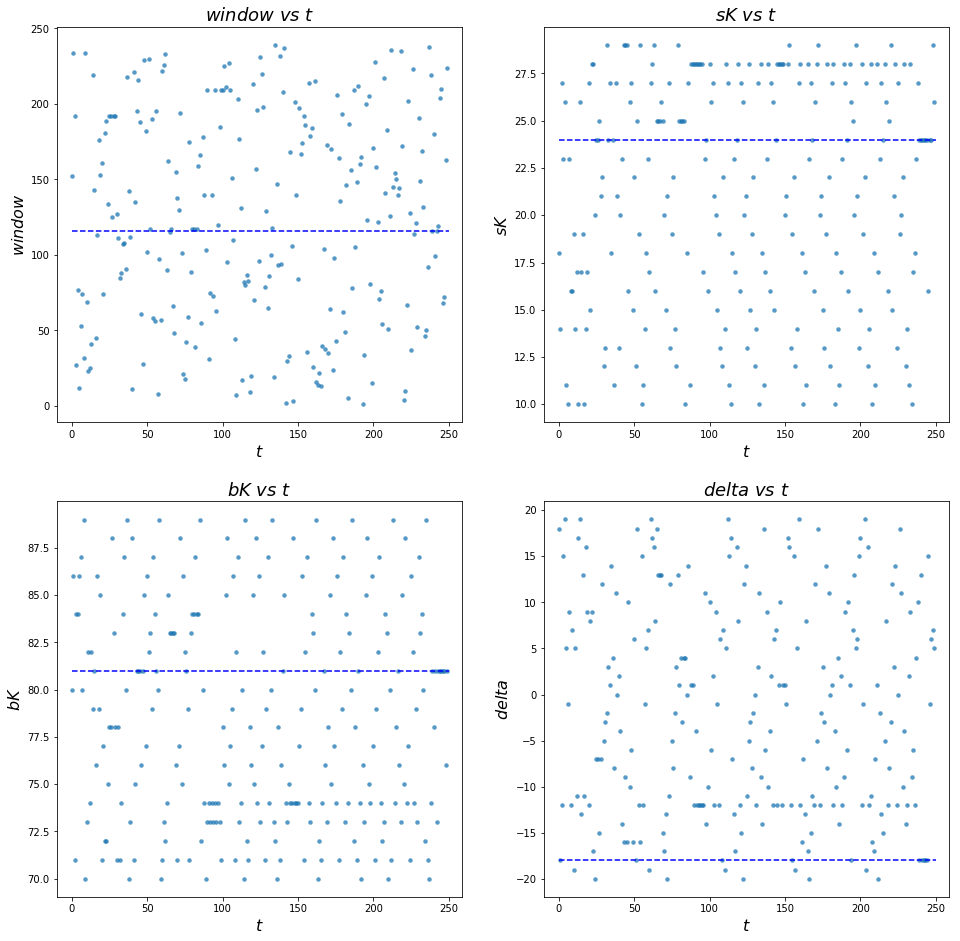

In [68]:
f, ax = plt.subplots(2, 2, figsize = (16, 16))
xs = [t['tid'] for t in trials.trials]
ys = [window_int[t['misc']['vals']['window'][0]] for t in trials.trials]
ax[0,0].set_xlim(xs[0]-10, xs[-1]+10)
ax[0,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,0].set_title('$window$ $vs$ $t$ ', fontsize=18)
ax[0,0].set_xlabel('$t$', fontsize=16)
ax[0,0].set_ylabel('$window$', fontsize=16)
ax[0,0].hlines(window_int[best['window']], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [sK_int[t['misc']['vals']['sK'][0]] for t in trials.trials]
ax[0,1].set_xlim(xs[0]-10, xs[-1]+10)
ax[0,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,1].set_title('$sK$ $vs$ $t$ ', fontsize=18)
ax[0,1].set_xlabel('$t$', fontsize=16)
ax[0,1].set_ylabel('$sK$', fontsize=16)
ax[0,1].hlines(sK_int[best['sK']], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [bK_int[t['misc']['vals']['bK'][0]] for t in trials.trials]
ax[1,0].set_xlim(xs[0]-10, xs[-1]+10)
ax[1,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,0].set_title('$bK$ $vs$ $t$ ', fontsize=18)
ax[1,0].set_xlabel('$t$', fontsize=16)
ax[1,0].set_ylabel('$bK$', fontsize=16)
ax[1,0].hlines(bK_int[best['bK']], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [delta_int[t['misc']['vals']['delta'][0]] for t in trials.trials]
ax[1,1].set_xlim(xs[0]-10, xs[-1]+10)
ax[1,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,1].set_title('$delta$ $vs$ $t$ ', fontsize=18)
ax[1,1].set_xlabel('$t$', fontsize=16)
ax[1,1].set_ylabel('$delta$', fontsize=16)
ax[1,1].hlines(delta_int[best['delta']], 0, 250,color='blue',linestyle="--")

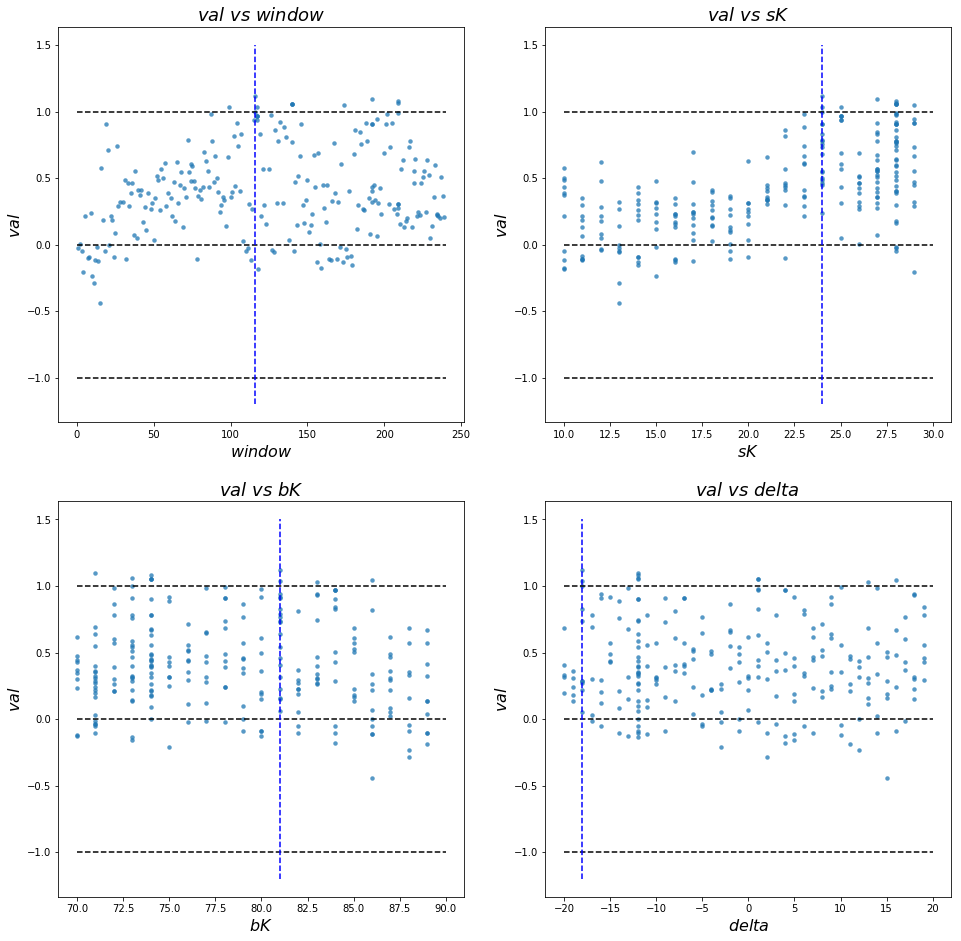

In [69]:
f, ax = plt.subplots(2,2, figsize = (16, 16))
xs = [window_int[t['misc']['vals']['window'][0]] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[0,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,0].set_title('$val$ $vs$ $window$ ', fontsize=18)
ax[0,0].set_xlabel('$window$', fontsize=16)
ax[0,0].set_ylabel('$val$', fontsize=16)
ax[0,0].hlines(0, 0, 240, color='black',linestyle="--")
ax[0,0].hlines(-1, 0, 240, color='black',linestyle="--")
ax[0,0].hlines(1, 0, 240, color='black',linestyle="--")
ax[0,0].vlines(window_int[best['window']], -1.2, 1.5, color='blue',linestyle="--")

xs = [sK_int[t['misc']['vals']['sK'][0]] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[0,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,1].set_title('$val$ $vs$ $sK$ ', fontsize=18)
ax[0,1].set_xlabel('$sK$', fontsize=16)
ax[0,1].set_ylabel('$val$', fontsize=16)
ax[0,1].hlines(0, 10, 30,color='black',linestyle="--")
ax[0,1].hlines(-1, 10, 30, color='black',linestyle="--")
ax[0,1].hlines(1, 10, 30,color='black',linestyle="--")
ax[0,1].vlines(sK_int[best['sK']], -1.2, 1.5, color='blue',linestyle="--")

xs = [bK_int[t['misc']['vals']['bK'][0]] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[1,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,0].set_title('$val$ $vs$ $bK$ ', fontsize=18)
ax[1,0].set_xlabel('$bK$', fontsize=16)
ax[1,0].set_ylabel('$val$', fontsize=16)
ax[1,0].hlines(0, 70, 90,color='black',linestyle="--")
ax[1,0].hlines(-1, 70, 90, color='black',linestyle="--")
ax[1,0].hlines(1, 70, 90,color='black',linestyle="--")
ax[1,0].vlines(bK_int[best['bK']], -1.2, 1.5, color='blue',linestyle="--")

xs = [delta_int[t['misc']['vals']['delta'][0]] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[1,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,1].set_title('$val$ $vs$ $delta$ ', fontsize=18)
ax[1,1].set_xlabel('$delta$', fontsize=16)
ax[1,1].set_ylabel('$val$', fontsize=16)
ax[1,1].hlines(0, -20, 20,color='black',linestyle="--")
ax[1,1].hlines(-1, -20, 20, color='black',linestyle="--")
ax[1,1].hlines(1, -20, 20,color='black',linestyle="--")
ax[1,1].vlines(delta_int[best['delta']], -1.2, 1.5, color='blue',linestyle="--")